In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
from keras.models import Model
import pandas as pd 
import os
from PIL import Image
from keras.models import Sequential
from keras.layers import Conv2D,MaxPooling2D,Flatten,Dense
import pickle
from tqdm import tqdm
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from tensorflow.keras.callbacks import EarlyStopping

In [3]:
### Import train data set
train_labels_df = pd.read_csv('./drive/MyDrive/ColabNotebooks/Projet_POTHOLE/train_ids_labels.csv')

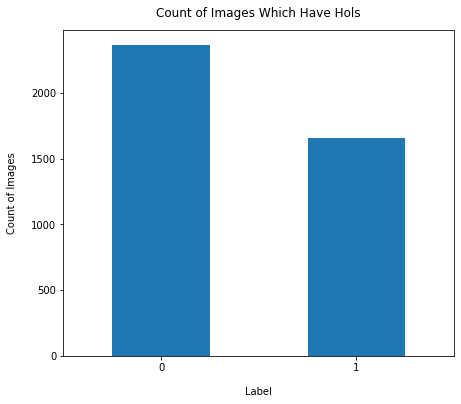

In [4]:
### EDA
train_labels_df['Label'].value_counts().plot(kind='bar', figsize=(7, 6), rot=0)
plt.xlabel("Label", labelpad=14)
plt.ylabel("Count of Images", labelpad=14)
plt.title("Count of Images Which Have Hols", y=1.02);

In [5]:
### Create dict{IMAGE_ID: Label}
labels_dict = dict(zip(train_labels_df["Image_ID"], train_labels_df["Label"]))

In [ ]:
#labels_dict['aaDNqCBveuwaZzV']

In [ ]:
img = Image.open('./drive/MyDrive/ColabNotebooks/Projet_POTHOLE/train/aAAwuvUBxwBSvhR.JPG')

In [ ]:
img.show()

In [6]:
## Function to get the images from folder
def get_train_set(filepath):
    ind = 1
    imgs = []
    labels = []
    print('Start reading files ... ')
    for f in os.listdir(filepath):
        labels.append(labels_dict[f.split('.')[0]])
        print('Reading file: ' + str(ind) + ' ' + f)  
        img = cv2.imread(filepath+f)
        img2 = cv2.resize(img, (150,150))
        imgs.append(img2)
        ind += 1
        #if ind == 1001:
        #    break
    print('Reading files finihsed ')
    return np.asarray(imgs), labels

In [7]:
images, labels = get_train_set("./drive/MyDrive/ColabNotebooks/Projet_POTHOLE/train/")

Start reading files ... 
Reading file: 1 tpdqJderLYgoHrM.JPG
Reading file: 2 tWMRimbFpBumKtM.JPG
Reading file: 3 tVDhHQbFVprGtYq.JPG
Reading file: 4 TvRocXPVbtFEdWc.JPG
Reading file: 5 TVAgVXmTsPmvIRj.JPG
Reading file: 6 tuFeNKicNTgzpas.JPG
Reading file: 7 TufMvINcSTLIfmw.JPG
Reading file: 8 tWOECCQgSjqNxno.JPG
Reading file: 9 tVlgjqlzqHPAuIU.JPG
Reading file: 10 TVFuYtKulZNaaTX.JPG
Reading file: 11 twmMzGrNtTgBJig.JPG
Reading file: 12 TVUVFVUlzmZszOG.JPG
Reading file: 13 ttmgpAIkunAYDpr.JPG
Reading file: 14 TvbaYEBZHCsLxNr.JPG
Reading file: 15 tvrMMRtMgUkMKyy.JPG
Reading file: 16 tuIDPsVcLHqCFaZ.JPG
Reading file: 17 tvWamQPtOlkJkEp.JPG
Reading file: 18 TVquxGXEJBEBJNm.JPG
Reading file: 19 TVApclyTKcmoWVJ.JPG
Reading file: 20 TWImshaKlAIDwAq.JPG
Reading file: 21 tUOYBKqasoDkPDP.JPG
Reading file: 22 TuVKiuVBcpAckRy.JPG
Reading file: 23 ttJbMcrkmSNBCrM.JPG
Reading file: 24 TtQzCuCYrlIwYaz.JPG
Reading file: 25 TvApeqMQccRdUNC.JPG
Reading file: 26 tvOONmTdviuQVrF.JPG
Reading file: 27 twgcs

In [8]:
type(images)

numpy.ndarray

In [9]:
lbls = np.array(labels)
#imgs = np.array(images)

In [10]:
images.shape

(4026, 150, 150, 3)

In [11]:
lbls = lbls.reshape(-1,1)

In [12]:
lbls.shape

(4026, 1)

In [13]:
### Split data to train set and test test
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(images,lbls,test_size=0.33,random_state=101)

In [14]:
x_train.shape

(2697, 150, 150, 3)

In [15]:
y_train.shape

(2697, 1)

In [16]:
train_label = np.asarray(y_train).astype('float32').reshape((-1,1))
test_label = np.asarray(y_test).astype('float32').reshape((-1,1))

In [ ]:
es = EarlyStopping(monitor='val_loss', mode='min')

Train step

In [17]:
### Transfert learning with ResNet50
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers,models


## loading resnet50 model
model_resnet50 = Sequential()
model_resnet50.add(ResNet50(include_top=False, pooling='max'))
model_resnet50.add(Flatten())
model_resnet50.add(Dense(1024, activation='relu'))
model_resnet50.add(layers.BatchNormalization())
model_resnet50.add(Dense(256, activation='relu'))
model_resnet50.add(layers.BatchNormalization())
model_resnet50.add(Dense(64, activation='relu'))
model_resnet50.add(layers.BatchNormalization())
model_resnet50.add(Dense(1, activation='sigmoid'))

model_resnet50.layers[0].trainable=False

model_resnet50.summary()

94765736/94765736 [==============================] - 5s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 1024)              2098176   
                                                                 
 batch_normalization (BatchN  (None, 1024)             4096      
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 256)               262400    
                                                                 
 batch_normalization_1 (Batc  (None, 256)              10

In [18]:
model_resnet50.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history_resnet50 = model_resnet50.fit(x_train, train_label, validation_split = 0.2, batch_size=32, epochs=20)

Epoch 1/20
68/68 [==============================] - 18s 96ms/step - loss: 0.3076 - accuracy: 0.8730 - val_loss: 0.4236 - val_accuracy: 0.8944
Epoch 2/20
68/68 [==============================] - 5s 68ms/step - loss: 0.1372 - accuracy: 0.9532 - val_loss: 0.1655 - val_accuracy: 0.9352
Epoch 3/20
68/68 [==============================] - 5s 71ms/step - loss: 0.0701 - accuracy: 0.9745 - val_loss: 0.1755 - val_accuracy: 0.9352
Epoch 4/20
68/68 [==============================] - 5s 68ms/step - loss: 0.0480 - accuracy: 0.9838 - val_loss: 0.2822 - val_accuracy: 0.9093
Epoch 5/20
68/68 [==============================] - 5s 69ms/step - loss: 0.0626 - accuracy: 0.9791 - val_loss: 0.2711 - val_accuracy: 0.9259
Epoch 6/20
68/68 [==============================] - 5s 70ms/step - loss: 0.0502 - accuracy: 0.9833 - val_loss: 0.2448 - val_accuracy: 0.9278
Epoch 7/20
68/68 [==============================] - 5s 70ms/step - loss: 0.0310 - accuracy: 0.9898 - val_loss: 0.1910 - val_accuracy: 0.9407
Epoch 8/20
6

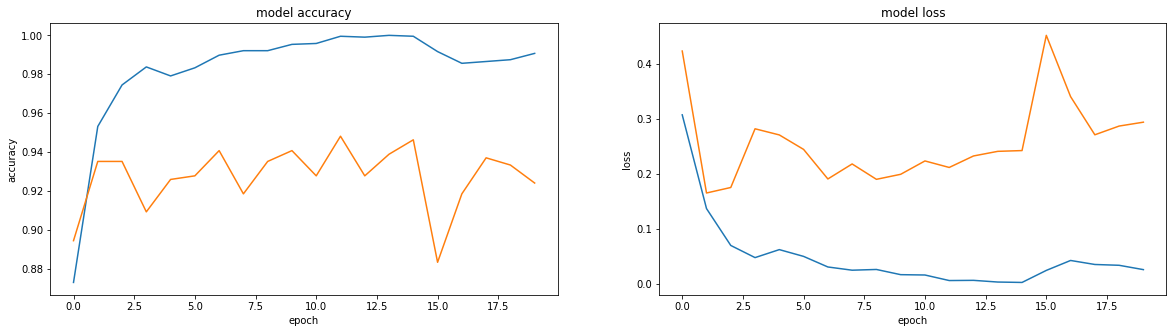

In [69]:
# Initialise the subplot function using number of rows and columns
figure, (axi1, axi2) = plt.subplots(1, 2, figsize=(20, 5))

# summarize history for accuracy
axi1.plot(history_resnet50.history['accuracy'])
axi1.plot(history_resnet50.history['val_accuracy'])
axi1.set_title('model accuracy')
axi1.set(xlabel='epoch', ylabel='accuracy')

# summarize history for loss
axi2.plot(history_resnet50.history['loss'])
axi2.plot(history_resnet50.history['val_loss'])
axi2.set_title('model loss')
axi2.set(xlabel='epoch', ylabel='loss')

plt.show()

In [33]:
# save the model to disk
model_path = './modelResNet50.h5'
model_resnet50.save(model_path)

In [34]:
### Transfert learning with VGG16
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
##loading vgg16 model
model1 = VGG16(weights="imagenet",include_top=False,input_shape=(150,150,3))
model1.trainable=False
##preprocessing input

58889256/58889256 [==============================] - 3s 0us/step


In [35]:
from tensorflow.keras import layers,models
model_VGG16 = Sequential([
    model1,
    layers.Flatten(),
    layers.Dense(256,activation='relu'),
    layers.Dense(64,activation='relu'),
    layers.Dense(1,activation='sigmoid')])

model_VGG16.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 8192)              0         
                                                                 
 dense_4 (Dense)             (None, 256)               2097408   
                                                                 
 dense_5 (Dense)             (None, 64)                16448     
                                                                 
 dense_6 (Dense)             (None, 1)                 65        
                                                                 
Total params: 16,828,609
Trainable params: 2,113,921
Non-trainable params: 14,714,688
_________________________________________________________________


In [36]:
model_VGG16.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history_vgg16 = model_VGG16.fit(x_train, train_label, validation_split = 0.2, batch_size=32, epochs=20)

Epoch 1/20
68/68 [==============================] - 12s 141ms/step - loss: 1.5414 - accuracy: 0.8586 - val_loss: 0.4041 - val_accuracy: 0.9241
Epoch 2/20
68/68 [==============================] - 7s 104ms/step - loss: 0.2035 - accuracy: 0.9578 - val_loss: 0.5715 - val_accuracy: 0.9037
Epoch 3/20
68/68 [==============================] - 7s 103ms/step - loss: 0.0780 - accuracy: 0.9777 - val_loss: 0.4225 - val_accuracy: 0.9315
Epoch 4/20
68/68 [==============================] - 7s 107ms/step - loss: 0.0174 - accuracy: 0.9944 - val_loss: 0.5237 - val_accuracy: 0.9426
Epoch 5/20
68/68 [==============================] - 7s 106ms/step - loss: 0.0099 - accuracy: 0.9981 - val_loss: 0.5436 - val_accuracy: 0.9407
Epoch 6/20
68/68 [==============================] - 7s 108ms/step - loss: 0.0097 - accuracy: 0.9958 - val_loss: 0.7356 - val_accuracy: 0.9352
Epoch 7/20
68/68 [==============================] - 7s 105ms/step - loss: 0.0066 - accuracy: 0.9977 - val_loss: 0.6683 - val_accuracy: 0.9315
Epoch

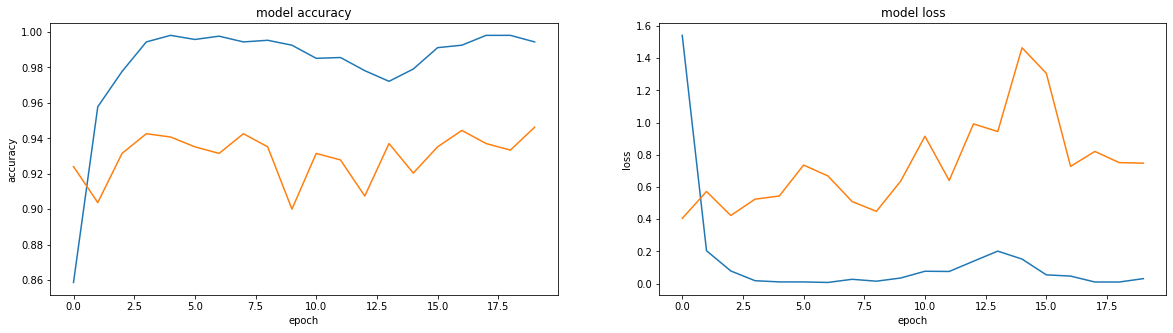

In [68]:
# Initialise the subplot function using number of rows and columns
figure, (axi1, axi2) = plt.subplots(1, 2, figsize=(20, 5))

# summarize history for accuracy
axi1.plot(history_vgg16.history['accuracy'])
axi1.plot(history_vgg16.history['val_accuracy'])
axi1.set_title('model accuracy')
axi1.set(xlabel='epoch', ylabel='accuracy')


# summarize history for loss
axi2.plot(history_vgg16.history['loss'])
axi2.plot(history_vgg16.history['val_loss'])
axi2.set_title('model loss')
axi2.set(xlabel='epoch', ylabel='loss')

plt.show()

In [40]:
# save the model to disk
model_path = './modelVGG16_150_64H1.h5'
model_VGG16.save(model_path)

In [ ]:
# load the model from disk
loaded_model = models.load_model(model_path)


In [73]:
# Transfer Learning with DenseNet201
from tensorflow.keras.applications import DenseNet201
conv_base = DenseNet201(input_shape=(150,150,3), include_top=False)

In [77]:
# Build the classifier
from tensorflow.keras import models, layers, optimizers, regularizers

model_densenet201 = models.Sequential()
#model_densenet201.add(conv_base)
model_densenet201.add(layers.Flatten())
model_densenet201.add(layers.Dense(128, activation='relu', input_shape=(4*4*1920,)))
model_densenet201.add(layers.Dropout(0.5))
model_densenet201.add(layers.Dense(256, activation='relu'))
model_densenet201.add(layers.Dense(1, activation='sigmoid'))

model_d= DenseNet201(weights='imagenet',include_top=False, input_shape=(150, 150, 3)) 

x=model_d.output

x= layers.GlobalAveragePooling2D()(x)
x= layers.BatchNormalization()(x)
x= layers.Dropout(0.5)(x)
x= layers.Dense(1024,activation='relu')(x) 
x= layers.Dense(512,activation='relu')(x) 
x= layers.BatchNormalization()(x)
x= layers.Dropout(0.5)(x)
preds=Dense(1,activation='sigmoid')(x) #FC-layer


In [ ]:
model_densenet201=Model(inputs=model_d.input,outputs=preds)
model_densenet201.summary()

In [80]:
# Compile the model
model_densenet201.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
# Fit the model
history_densenet201 = model_densenet201.fit(x_train, y_train, epochs=20, validation_split=0.2, batch_size=32)

Epoch 1/20
68/68 [==============================] - 42s 339ms/step - loss: 0.5189 - acc: 0.8173 - val_loss: 3.1078 - val_acc: 0.5370
Epoch 2/20
68/68 [==============================] - 19s 282ms/step - loss: 0.2241 - acc: 0.9138 - val_loss: 0.6272 - val_acc: 0.7648
Epoch 3/20
68/68 [==============================] - 20s 289ms/step - loss: 0.1715 - acc: 0.9337 - val_loss: 0.3926 - val_acc: 0.8278
Epoch 4/20
68/68 [==============================] - 20s 296ms/step - loss: 0.1466 - acc: 0.9379 - val_loss: 0.2666 - val_acc: 0.9074
Epoch 5/20
68/68 [==============================] - 23s 335ms/step - loss: 0.1008 - acc: 0.9611 - val_loss: 1.0400 - val_acc: 0.7444
Epoch 6/20
68/68 [==============================] - 20s 296ms/step - loss: 0.0879 - acc: 0.9689 - val_loss: 0.1636 - val_acc: 0.9463
Epoch 7/20
68/68 [==============================] - 21s 306ms/step - loss: 0.0596 - acc: 0.9754 - val_loss: 0.3459 - val_acc: 0.8352
Epoch 8/20
68/68 [==============================] - 21s 311ms/step - 

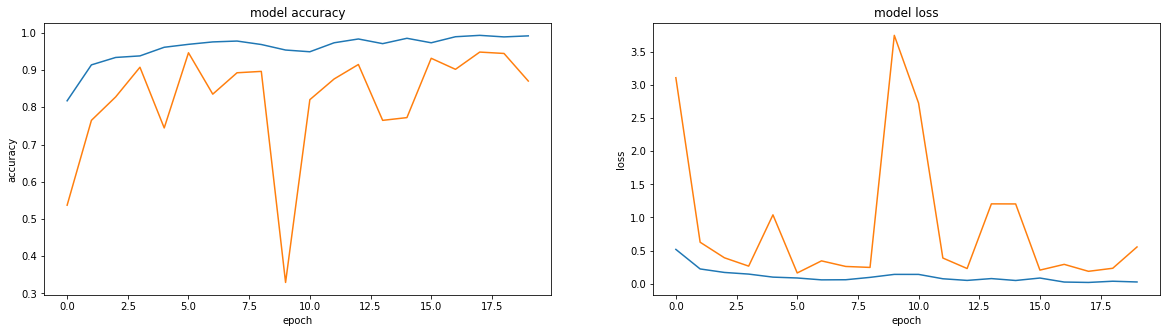

In [82]:
# Initialise the subplot function using number of rows and columns
figure, (axi1, axi2) = plt.subplots(1, 2, figsize=(20, 5))

# summarize history for accuracy
axi1.plot(history_densenet201.history['acc'])
axi1.plot(history_densenet201.history['val_acc'])
axi1.set_title('model accuracy')
axi1.set(xlabel='epoch', ylabel='accuracy')


# summarize history for loss
axi2.plot(history_densenet201.history['loss'])
axi2.plot(history_densenet201.history['val_loss'])
axi2.set_title('model loss')
axi2.set(xlabel='epoch', ylabel='loss')

plt.show()

In [63]:
### Model with traditionnel CNN 
model_CNN = Sequential([
  Conv2D(32, (5,5), activation='relu', input_shape=(x_train.shape[1],x_train.shape[2],3)),
  MaxPooling2D(4, 4),
  Conv2D(64, (3,3), activation='relu', input_shape=(x_train.shape[1],x_train.shape[2],3)),
  MaxPooling2D(2, 2),
  Conv2D(128, (3,3), activation='relu', input_shape=(x_train.shape[1],x_train.shape[2],3)),
  MaxPooling2D(2, 2),
  Flatten(),
  Dense(256, activation='relu'),
  Dense(128, activation='relu'),
  Dense(1, activation='sigmoid')
])

model_CNN.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 146, 146, 32)      2432      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 36, 36, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 34, 34, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 17, 17, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 15, 15, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 7, 7, 128)       

In [64]:
model_CNN.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history_CNN = model_CNN.fit(x_train, train_label, validation_split = 0.2, batch_size=32, epochs=20)

Epoch 1/20
68/68 [==============================] - 3s 29ms/step - loss: 3.4635 - accuracy: 0.6959 - val_loss: 0.4457 - val_accuracy: 0.8111
Epoch 2/20
68/68 [==============================] - 1s 19ms/step - loss: 0.4738 - accuracy: 0.8011 - val_loss: 0.4351 - val_accuracy: 0.8370
Epoch 3/20
68/68 [==============================] - 1s 22ms/step - loss: 0.4038 - accuracy: 0.8229 - val_loss: 0.3215 - val_accuracy: 0.8722
Epoch 4/20
68/68 [==============================] - 1s 22ms/step - loss: 0.4060 - accuracy: 0.8289 - val_loss: 0.3662 - val_accuracy: 0.8352
Epoch 5/20
68/68 [==============================] - 1s 22ms/step - loss: 0.3734 - accuracy: 0.8373 - val_loss: 0.3517 - val_accuracy: 0.8574
Epoch 6/20
68/68 [==============================] - 1s 20ms/step - loss: 0.4239 - accuracy: 0.8285 - val_loss: 0.3516 - val_accuracy: 0.8574
Epoch 7/20
68/68 [==============================] - 1s 20ms/step - loss: 0.3633 - accuracy: 0.8498 - val_loss: 0.2816 - val_accuracy: 0.8926
Epoch 8/20
68

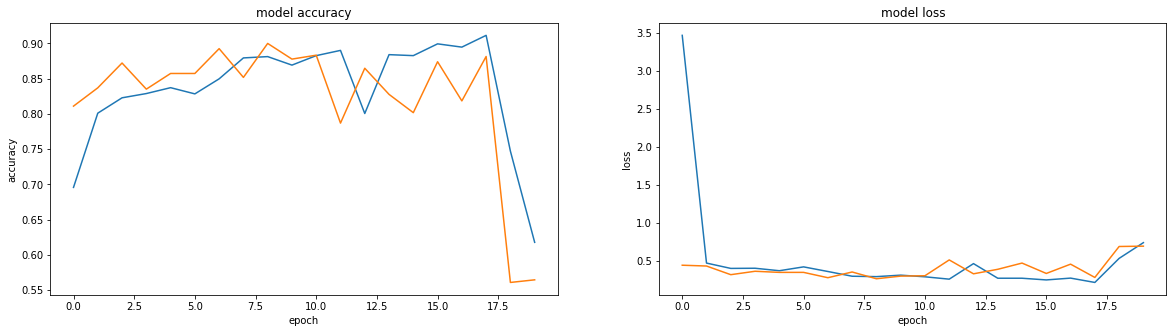

In [70]:
# Initialise the subplot function using number of rows and columns
figure, (axi1, axi2) = plt.subplots(1, 2, figsize=(20, 5))

# summarize history for accuracy
axi1.plot(history_CNN.history['accuracy'])
axi1.plot(history_CNN.history['val_accuracy'])
axi1.set_title('model accuracy')
axi1.set(xlabel='epoch', ylabel='accuracy')


# summarize history for loss
axi2.plot(history_CNN.history['loss'])
axi2.plot(history_CNN.history['val_loss'])
axi2.set_title('model loss')
axi2.set(xlabel='epoch', ylabel='loss')

plt.show()

In [ ]:

# Compute fpr, tpr, thresholds and roc auc
fpr, tpr, thresholds = roc_curve(y_test,preds0)
roc_auc = auc(fpr, tpr)

In [ ]:
#model makes a prediction
preds = model_CNN.predict(x_test)

#get a sample of the preds dataframe
preds

42/42 [==============================] - 1s 18ms/step


array([[0.25806218],
       [0.10576671],
       [0.02006397],
       ...,
       [0.07886995],
       [0.04442428],
       [0.56437004]], dtype=float32)

In [ ]:
predicts = [1 if x > 0.5 else 0 for x in preds]

In [83]:
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import classification_report

In [87]:
# Define a result table as a DataFrame
result_table = pd.DataFrame(columns=['classifiers', 'fpr','tpr','auc'])

classfrs = [model_CNN, model_VGG16, model_resnet50, model_densenet201]
classifiers = ['CNN', 'VGG16', 'resnet50', 'densenet201']

ind = 0
# Train the models and record the results
for cls in classfrs:
    ypreds = cls.predict(x_test)
    
    fpr, tpr, _ = roc_curve(test_label,  ypreds)
    auc = roc_auc_score(test_label, ypreds)
    
    result_table = result_table.append({'classifiers':classifiers[ind],
                                        'fpr':fpr, 
                                        'tpr':tpr, 
                                        'auc':auc}, ignore_index=True)
    print()
    print(classifiers[ind])

    predicts = [1 if x > 0.5 else 0 for x in ypreds]
    print(classification_report(test_label, predicts))
    
    ind += 1

# Set name of the classifiers as index labels
result_table.set_index('classifiers', inplace=True)


42/42 [==============================] - 0s 9ms/step

CNN
              precision    recall  f1-score   support

         0.0       0.57      1.00      0.72       752
         1.0       0.00      0.00      0.00       577

    accuracy                           0.57      1329
   macro avg       0.28      0.50      0.36      1329
weighted avg       0.32      0.57      0.41      1329

 2/42 [>.............................] - ETA: 2s

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


42/42 [==============================] - 3s 79ms/step

VGG16
              precision    recall  f1-score   support

         0.0       0.96      0.95      0.95       752
         1.0       0.93      0.95      0.94       577

    accuracy                           0.95      1329
   macro avg       0.95      0.95      0.95      1329
weighted avg       0.95      0.95      0.95      1329

42/42 [==============================] - 2s 51ms/step

resnet50
              precision    recall  f1-score   support

         0.0       0.95      0.91      0.93       752
         1.0       0.89      0.94      0.91       577

    accuracy                           0.92      1329
   macro avg       0.92      0.92      0.92      1329
weighted avg       0.92      0.92      0.92      1329

42/42 [==============================] - 3s 72ms/step

densenet201
              precision    recall  f1-score   support

         0.0       0.83      1.00      0.90       752
         1.0       1.00      0.72      0.84  

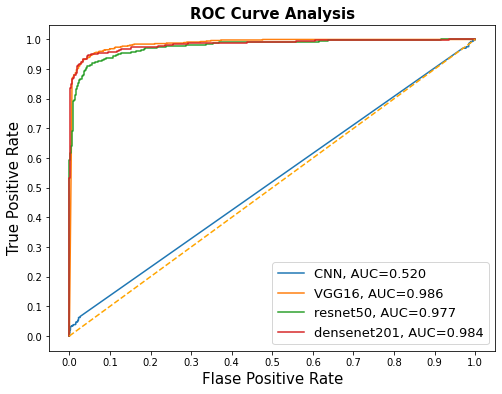

In [88]:

fig = plt.figure(figsize=(8,6))

for i in result_table.index:
    plt.plot(result_table.loc[i]['fpr'], 
             result_table.loc[i]['tpr'], 
             label="{}, AUC={:.3f}".format(i, result_table.loc[i]['auc']))
    
plt.plot([0,1], [0,1], color='orange', linestyle='--')

plt.xticks(np.arange(0.0, 1.1, step=0.1))
plt.xlabel("Flase Positive Rate", fontsize=15)

plt.yticks(np.arange(0.0, 1.1, step=0.1))
plt.ylabel("True Positive Rate", fontsize=15)

plt.title('ROC Curve Analysis', fontweight='bold', fontsize=15)
plt.legend(prop={'size':13}, loc='lower right')

plt.show()

Test on zindi test data set

In [91]:
test_labels_df = pd.read_csv('./drive/MyDrive/ColabNotebooks/Projet_POTHOLE/test_ids_only.csv')

In [89]:
########### Tester sur les images de train set 
def get_test_set(filepath, images_IDs):
    ind = 1
    imgs = []
    print('Start reading files ... ')
    for f in images_IDs:
        print('Reading file: ' + str(ind) + ' ' + f)  
        img = cv2.imread(filepath+f+".JPG")
        img2 = cv2.resize(img, (150,150))
        imgs.append(img2)
        ind += 1
    print('Reading files finihsed ')
    return np.asarray(imgs)

In [ ]:
test_images = get_test_set("./drive/MyDrive/ColabNotebooks/Projet_POTHOLE/test/", np.array(test_labels_df['Image_ID']))

Start reading files ... 
Reading file: 1 nRhHxqLhDlJsiXc
Reading file: 2 gbSntVovxgHQrmO
Reading file: 3 nqOobGmvgEOiPms
Reading file: 4 oIkPTooLcIbZKlF
Reading file: 5 eSKxsTTJDQzkjgD
Reading file: 6 fGOKonqqErFfiuK
Reading file: 7 UZPfNzWrCgFaaNz
Reading file: 8 kvesbcrtTOohiLT
Reading file: 9 cdEZEDZaveknkKa
Reading file: 10 GaSSOeqyIktsAmW
Reading file: 11 HPeQFgWaAXYUudP
Reading file: 12 QCiNkpJJqhUrhJw
Reading file: 13 ZghFqBtZjgFNhEd
Reading file: 14 IypiZpxWuQzqFtX
Reading file: 15 MpjOfMFyHcLtxEe
Reading file: 16 jtyOoBrAZpMYhPd
Reading file: 17 xKSvNuUFXtfsxcL
Reading file: 18 PxzQoNBqWwxhxHU
Reading file: 19 eBIGOMITtVDxgco
Reading file: 20 YGldCVpEhmDhCfB
Reading file: 21 YsIrfIbUTFAVLuA
Reading file: 22 BADSMkRmwapihnH
Reading file: 23 zRjjLRTcHldvsDO
Reading file: 24 uxiNbcCqYnHBdoT
Reading file: 25 MEPpiRYJgJLRYpW
Reading file: 26 YIUlgjNqemMwGtW
Reading file: 27 jBduUjHTqYJvtVv
Reading file: 28 yXCylbJUfTvbPcj
Reading file: 29 OcTWRvWjeDQRbVu
Reading file: 30 UIRJNpxPYf

In [ ]:
test_images.shape

(1650, 100, 100, 3)

In [ ]:
len(test_labels_df)

1650

In [ ]:
test_images.shape

(1650, 100, 100, 3)

In [ ]:
#model makes a prediction
submission = model.predict(test_images)

52/52 [==============================] - 2s 36ms/step


In [ ]:
submission

array([[5.4604893e-06],
       [1.1867971e-09],
       [1.4124703e-16],
       ...,
       [1.0000000e+00],
       [2.9199272e-01],
       [7.9419367e-02]], dtype=float32)

In [ ]:
test_labels_df['Label'] = submission

In [ ]:
df = test_labels_df.set_index('Image_ID')

In [ ]:
test_labels_df

,Image_ID,Label
0,nRhHxqLhDlJsiXc,5.460489e-06
1,gbSntVovxgHQrmO,1.186797e-09
2,nqOobGmvgEOiPms,1.412470e-16
3,oIkPTooLcIbZKlF,1.000000e+00
4,eSKxsTTJDQzkjgD,9.996833e-01
...,...,...
1645,BmSrWvzrriPuQOh,1.252208e-12
1646,HfXCITRCHqrLOda,2.582161e-04
1647,uQLYKtTCnvWWGVu,1.000000e+00
1648,gYWbwjUOZrOlTzQ,2.919927e-01


In [ ]:

#here we are converting to a csv file
df.to_csv('./drive/MyDrive/ColabNotebooks/Projet_POTHOLE/submission1.csv')